# Imports

In [5]:
import tensorflow as tf 
from tensorflow import keras 
import sklearn
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib as mplb 
import matplotlib.pyplot as plt 
#plt.style.use('ggplot')
import numpy as np
import pandas as pd 

import seaborn as sns

import os 
import zipfile
import shutil
import getpass
import requests
from IPython.display import clear_output
from tqdm.notebook import tqdm
import datetime

%load_ext tensorboard
print(f'[INFO] Using tensorflow-gpu {tf.__version__}')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[INFO] Using tensorflow-gpu 2.3.0


# Config

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_val = 2020

# set seed 
np.random.seed(seed=seed_val)

tf.random.set_seed(seed=seed_val)

# Params

In [7]:
IMG_SIZE = 224
IMG_SHAPE  = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
class_names = ['NEG', 'POS']
base_dir = '../'
train_images_dir = os.path.join(base_dir, 'Datasets/Images', 'train')
val_images_dir = os.path.join(base_dir, 'Datasets/Images', 'val')
test_images_dir = os.path.join(base_dir, 'Datasets/Images', 'test')

train_csv_path = os.path.join(base_dir, 'Datasets/Csv', 'Train.csv')
test_csv_path = os.path.join(base_dir, 'Datasets/Csv', 'Test.csv')
sample_csv_path = os.path.join(base_dir, 'Datasets/Csv', 'Train.csv')

In [8]:
train_df  = pd.read_csv(train_csv_path)
test_df  = pd.read_csv(test_csv_path)
sample_sub_df = pd.read_csv(sample_csv_path)

In [9]:
train_df.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [10]:
test_df.head()

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD
2,test/TBLBHSYT.png,TBLBHSYT
3,test/ZKETEOFG.png,ZKETEOFG
4,test/GKTPBGZP.png,GKTPBGZP


In [11]:
sample_sub_df.tail()

,filename,ID,LABEL
713,train/EWGJDECH.png,EWGJDECH,1
714,train/CJEVKQUT.png,CJEVKQUT,1
715,train/YDXXBDGI.png,YDXXBDGI,1
716,train/QLUOORWZ.png,QLUOORWZ,0
717,train/HFAGCLGV.png,HFAGCLGV,1


# Datasets & Dataloaders

In [39]:
image_generator = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                                width_shift_range=0.3,
                                                                height_shift_range=0.1,
                                                                zoom_range=0.1,
                                                                fill_mode='nearest',
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255.0,
                                                                validation_split=0.2)


In [40]:
train_generator = image_generator.flow_from_directory(directory=train_images_dir+'/train', 
                                                      target_size=(IMG_SIZE, IMG_SIZE), 
                                                      batch_size=BATCH_SIZE, 
                                                      seed=seed_val, 
                                                      subset='training')

validation_generator = image_generator.flow_from_directory(directory=train_images_dir+'/train', 
                                                      target_size=(IMG_SIZE, IMG_SIZE), 
                                                      batch_size=BATCH_SIZE, 
                                                      seed=seed_val, 
                                                      subset='validation')

Found 575 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


In [41]:
for imgs, labels in train_generator:
    print(f"First image  shape : {imgs[0].shape}, label : {labels[0]}")
    break

First image  shape : (224, 224, 3), label : [1. 0.]


In [11]:
# traditional image loading 
def get_train_images_and_labels():
    train_images_list = []
    train_labels_list = []

    for folder in os.listdir(os.path.join(train_images_dir, 'train')):
        try:
            for img in tqdm(os.listdir(os.path.join(train_images_dir, 'train', folder)), desc=f"Now on folder {folder}"):
                x = keras.preprocessing.image.load_img(path=os.path.join(train_images_dir, 'train', folder, img), 
                                                       target_size=(IMG_SIZE, IMG_SIZE))

                x = keras.preprocessing.image.img_to_array(x)
                train_images_list.append(x)
                if folder == "TB-0":
                    label = np.eye(2)[0]
                else:
                    label = np.eye(2)[1]

                train_labels_list.append(label)
        except:
            pass
        
    return np.array(train_images_list), np.array(train_labels_list)



train_images_list, train_labels_list = get_train_images_and_labels()

In [12]:
len(train_images_list), len(train_labels_list)

(718, 718)

# Visualization

In [42]:
def show_training_sample(batch_size=BATCH_SIZE):
    imgs, labs = next(iter(train_generator))
    plt.figure(figsize=(22, 18))
    for i in range(min(25, batch_size)):
        l, c = 5, 5
        img = imgs[i]
        label = class_names[tf.argmax(labs[i])]
        ax = plt.subplot(l, c, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        
        
        
        
        


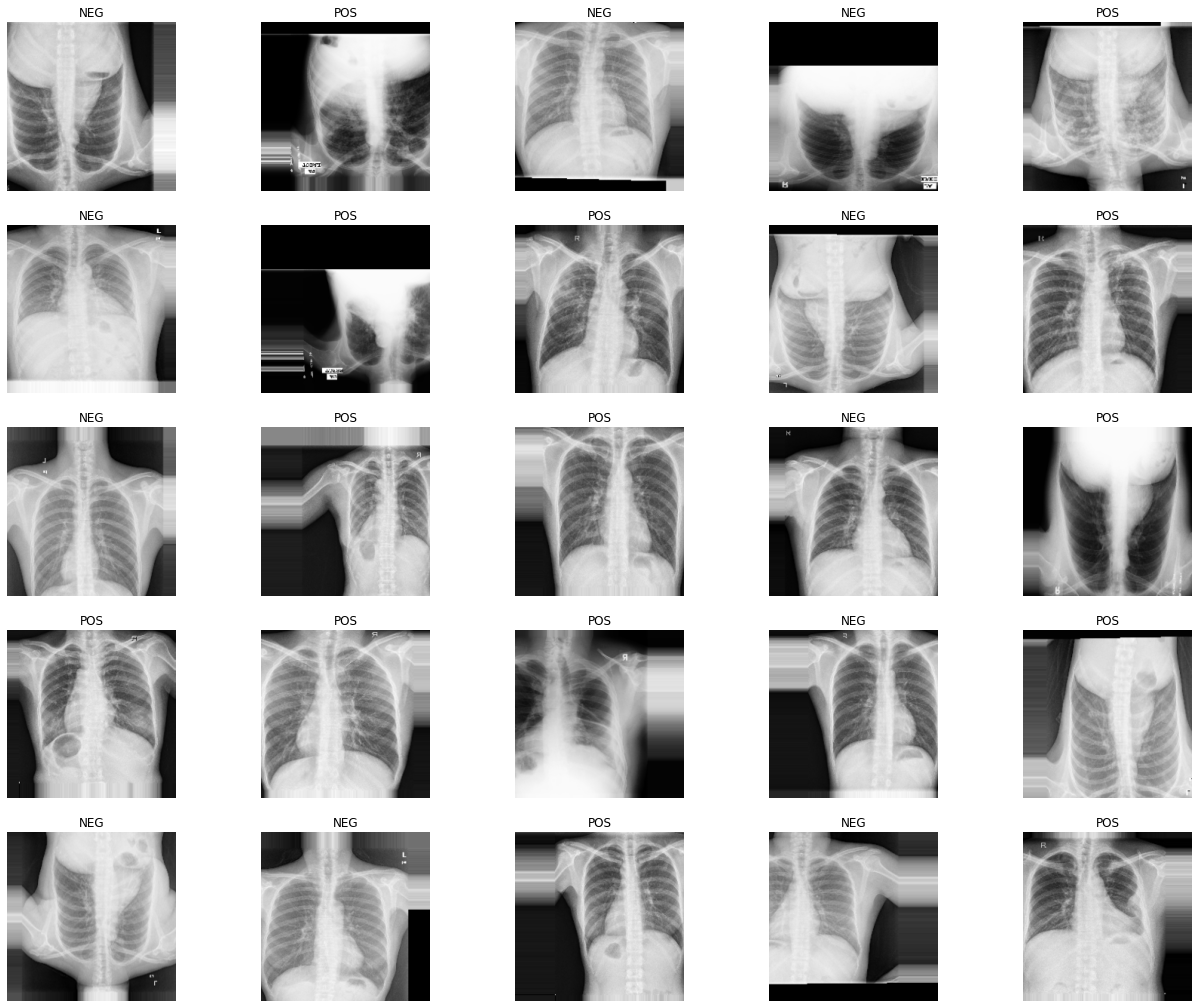

In [43]:
show_training_sample()

In [44]:
arch_name = "EfficientNetB1"
base_arch = getattr(tf.keras.applications, arch_name) 
base_model = base_arch(include_top=False, input_shape=IMG_SHAPE)

27025408/27018416 [==============================] - 10s 0us/step


In [45]:
# freeze trained layers
for layer in base_model.layers:
    layer.trainable = False


def build_model(fc_size=2, n_dense_units=512):
    
    inputs = inputs = keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(units=n_dense_units, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    if fc_size > 1:
        predictions = keras.layers.Dense(units=fc_size, activation="softmax")(x)
        
    else:
        predictions = keras.layers.Dense(units=1, activation="sigmoid")(x)
    
    model = keras.Model(inputs = inputs, outputs=predictions)
    
    return model

In [46]:
model = build_model(fc_size=2, n_dense_units=128)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 6,739,465
Trainable params: 164,226
Non-trainable params: 6,575,239
______________________________________

# Training phase

In [47]:
# training params 
# optimizer
lr = 3e-4
optimizer = keras.optimizers.Adam(learning_rate=lr)

# loss 
loss_fn = keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['AUC'])

num_epochs = 30
optim_name = optimizer.get_config()['name']
model_name = f'tf_model_x_rays_based_on_{arch_name}_and_{optim_name}.h5'
model_path = os.path.join(base_dir, 'Models', model_name)

# CALLBACKS 
auc_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, 
                                           verbose=1, 
                                           monitor='val_auc', 
                                           mode='max',
                                           save_best_only=True)

acc_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, 
                                           verbose=1, 
                                           mode='max',
                                           monitor='val_accuracy', 
                                           save_best_only=True)

loss_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, 
                                            verbose=1, 
                                            mode='min',
                                            monitor='val_loss', 
                                            save_best_only=True)

es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   patience=20, 
                                   verbose=1, 
                                   restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', 
                                                 factor=0.1, 
                                                 patience=10, 
                                                verbose=1, 
                                                 mode='max', 
                                                 min_lr=lr)

LOGDIR = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(LOGDIR, histogram_freq=1)

# bot config
#bot_callback = botCallback(access_token=access_token)
#plotter = Plotter(access_token)

CALLBACKS = [auc_ckpt, loss_ckpt, es, reduce_lr, tensorboard_callback] #bot_callback, plotter]

In [26]:
h = model.fit(train_generator, 
              validation_data=validation_generator, 
              epochs=num_epochs, 
              steps_per_epoch=train_generator.n // BATCH_SIZE,
              validation_steps=validation_generator.n // BATCH_SIZE, 
              callbacks=CALLBACKS)

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.5586 - auc: 0.8060
Epoch 00001: val_auc improved from inf to 0.92316, saving model to ../Models/tf_model_x_rays_based_on_EfficientNetB0_and_Adam.h5

Epoch 00001: val_loss improved from inf to 0.36759, saving model to ../Models/tf_model_x_rays_based_on_EfficientNetB0_and_Adam.h5
35/35 [==============================] - 97s 3s/step - loss: 0.5586 - auc: 0.8060 - val_loss: 0.3676 - val_auc: 0.9232
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.4720 - auc: 0.8612
Epoch 00002: val_auc improved from 0.92316 to 0.88068, saving model to ../Models/tf_model_x_rays_based_on_EfficientNetB0_and_Adam.h5

Epoch 00002: val_loss did not improve from 0.36759
35/35 [==============================] - 78s 2s/step - loss: 0.4720 - auc: 0.8612 - val_loss: 0.4437 - val_auc: 0.8807
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.4601 - auc: 0.8676
Epoch 00003: val_auc did not improve from 0.88068


KeyboardInterrupt: 

# cross validation

# Results

In [ ]:
y_hat = model.predict(validation_generator)

In [ ]:
validation_generator.labels

In [ ]:

fpr, tpr, thresholds = roc_curve(y_, y_hat)
plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr)
x = np.linspace(0,1,num=50)
plt.plot(x,x,color='lightgrey',linestyle='--',marker='',lw=2,label='random guess')
plt.legend(fontsize = 14)
plt.xlabel('False positive rate', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()



try:
    for h in histories:
        plt.figure(figsize=(20,5))
        loss = h.history['loss']
        acc = h.history['accuracy']
        val_loss = h.history['val_loss']
        val_acc = h.history['val_accuracy']

        plt.subplot(1, 2, 1)
        plt.plot(loss, label='training loss')
        plt.plot(val_loss, label='validation loss')
        plt.title("Losses results", size=16)
        plt.xlabel("epoch")
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(acc, label='training acc')
        plt.plot(val_acc, label='validation acc')
        plt.title("Accuracies results", size=16)
        plt.xlabel("epoch")
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()
        
except:
    plt.figure(figsize=(20,6))
    loss = h.history['loss']
    acc = h.history['accuracy']
    val_loss = h.history['val_loss']
    val_acc = h.history['val_accuracy']

    plt.subplot(1, 2, 1)
    plt.plot(loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.title("Losses results", size=16)
    plt.xlabel("epoch")
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc, label='training acc')
    plt.plot(val_acc, label='validation acc')
    plt.title("Accuracies results", size=16)
    plt.xlabel("epoch")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [49]:
%tensorboard --logdir LOGDIR 

# Predictions

In [20]:
def load_models(cv_models_path = os.path.join(base_dir, 'Models', 'CV_models'), optim_name="Adam"):
    models = []
    n_folds = 5
    try:
        for fold_num in range(1, n_folds+1):
            m = keras.models.load_model(os.path.join(cv_models_path, f"tf_xrays_model_based_on_{arch_name}_and_{optim_name}_fold_{fold_num}.h5"))
            m.trainable = False
            models.append(m)
    except :
        model.trainable = False
        models.append(model)
        
    return models


models = load_models(optim_name=optim_name)
    
len(models)

1

In [22]:
def test_step(models):
    images_test = []
    predictions = []
    
    for im in tqdm(os.listdir(os.path.join(test_images_dir, 'test')), desc=f"Predicting on test images "):
        images_test.append(im.split('.')[0])
        x = keras.preprocessing.image.load_img(os.path.join(test_images_dir, 'test', im), target_size=(IMG_SIZE, IMG_SIZE))
        x = keras.preprocessing.image.img_to_array(x)
        
        tmp_preds = []
        for model in models: 
            pred = model.predict(x.reshape(-1, IMG_SIZE, IMG_SIZE, 3))[0][1]# get column 1 of prediction
            tmp_preds.append(pred)
        
        predictions.append(np.array(tmp_preds).mean())
                
    return images_test, predictions


images_test, predictions = test_step(models = models)

assert len(predictions) == len(images_test)

In [23]:
my_file = pd.DataFrame({
    'ID': images_test,
    'LABEL':predictions
})

my_file

,ID,LABEL
0,BPMOOTCZ,0.992457
1,CHDDLHBE,0.199309
2,OUDDWOML,0.069136
3,XZCNSJAC,0.976891
4,RIHEHUTM,0.039809
...,...,...
77,LWOMGDGX,0.444347
78,JUQVMIEU,0.484490
79,FTBBVMHK,0.997971
80,XFBRFQRL,0.038616


In [25]:
if len(models) > 1:
    file_name = f'tf_xrays_based_on_{arch_name}_optimizer_{optim_name}_bs_{BATCH_SIZE}_ep_{num_epochs}_lr_{lr}_n_folds_{num_folds}.csv'
else:
    file_name = f'tf_xrays_based_on_{arch_name}_optimizer_{optim_name}_bs_{BATCH_SIZE}_ep_{num_epochs}_lr_{lr}.csv'
    
    
    
    
my_file.to_csv(os.path.join(base_dir, 'Submissions', file_name), index=False)

print(f"[INFO] Saved file as {file_name}")

[INFO] Saved file as tf_xrays_based_on_ResNet101_optimizer_Adam_bs_32_ep_36_lr_0.00099.csv
